In [62]:
import os
from matplotlib import pyplot as plt
import numpy as np
import nibabel as nib
import polars as pl
from tqdm import tqdm
import seaborn as sns
import polars as pl
import pickle
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.cm as cm

In [ ]:
plt.style.use("seaborn-v0_8-white")

In [7]:
ROOT = os.getcwd()
PREDICTED_DIR = os.path.join(ROOT, "predicted")
TRUE_DIR = os.path.join(ROOT, "workspace/test/labelsTs/true")

In [8]:
with open(os.path.join(PREDICTED_DIR, "pdac-likelihood.json"), "r") as f:
    data = json.load(f)

# Convert the dict to a list of dicts and create a DataFrame
rows = [{"id": key, "pdac_likelihood": value} for key, value in data.items()]
predicted_pdac_scores = pl.DataFrame(
    rows,
    schema={
        "id": pl.Utf8,
        "pdac_likelihood": pl.Float64,
    },
)

In [4]:
predicted_pdac_scores

id,pdac_likelihood
str,f64
"""100006_00001_0000""",0.424344
"""100010_00001_0000""",0.002501
"""100020_00001_0000""",0.002595
"""100022_00001_0000""",0.002199
"""100023_00001_0000""",0.005653
…,…
"""100146_00001_0000""",0.003453
"""100149_00001_0000""",0.013529
"""100155_00001_0000""",0.73462


In [9]:
label_annotations = {
    0: "Background",
    1: "PDAC lesion",
    2: "Veins",
    3: "Arteries",
    4: "Pancreas parenchyma",
    5: "Pancreatic duct",
    6: "Common bile duct",
}

In [70]:
PDAC_LABEL = 1

In [10]:
true_labels = os.listdir(TRUE_DIR)

In [ ]:
def get_label_distribution_for_image_labels(label_image_path: str) -> dict:
    label_image = nib.load(os.path.join(TRUE_DIR, label_image_path))
    data_arr = np.asanyarray(label_image.dataobj)
    unique, counts = np.unique(data_arr, return_counts=True)

    return {int(unique[i]): int(counts[i]) for i in range(len(unique))}

In [15]:
get_label_distribution_for_image_labels(true_labels[0])

{0: 52577188, 1: 17235, 2: 13229, 3: 34484, 4: 48115, 5: 142, 6: 551}

In [ ]:
def get_image_with_true_labels(image_id: str) -> np.ndarray:
    label_image = nib.load(os.path.join(TRUE_DIR, image_id))
    data_arr = np.asanyarray(label_image.dataobj)
    return data_arr

In [ ]:
# 3d image

In [ ]:
true_label_image = nib.load("workspace/test/labelsTs/true/100006_00001.nii.gz")
image_arr = np.asanyarray(true_label_image.dataobj)
image_arr.shape

(512, 512, 240)

In [40]:
image_arr.shape

(81, 81, 53)

In [ ]:
predicted_label_image = np.load(
    "workspace/test/labelsTs/predicted/itm/LowPred/100006_00001_0000.npz"
)
predicted_label_image.get("probabilities").shape

(2, 53, 81, 81)

In [ ]:
file = open("workspace/test/labelsTs/predicted/itm/LowPred/100006_00001_0000.pkl", "rb")

# dump information to that file
data = pickle.load(file)

In [52]:
data

{'sitk_stuff': {'spacing': (4.5, 4.5, 9.0),
  'origin': (-187.94276428222656, -70.68574523925781, -517.0),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)},
 'spacing': [np.float64(9.0), np.float64(4.5), np.float64(4.5)],
 'shape_before_cropping': (53, 81, 81),
 'bbox_used_for_cropping': [[0, 53], [0, 81], [0, 81]],
 'shape_after_cropping_and_before_resampling': (53, 81, 81)}

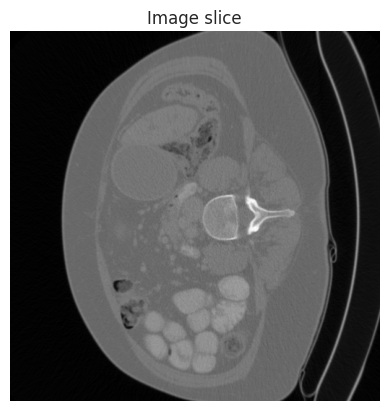

In [ ]:
# middle image slice
image = nib.load("workspace/test/imagesTs/100006_00001_0000.nii.gz")
image_arr = np.asanyarray(image.dataobj)
slice_index = image_arr.shape[2] // 2
image_slice = image_arr[:, :, slice_index]
plt.imshow(image_slice, cmap="gray")
plt.axis("off")
plt.title("Image slice")
plt.show()

In [ ]:
colors = [
    "lightgray",  # 0: Background
    "red",  # 1: PDAC lesion (make it very visible!)
    "blue",  # 2: Veins
    "green",  # 3: Arteries
    "orange",  # 4: Pancreas parenchyma
    "purple",  # 5: Pancreatic duct
    "brown",  # 6: Common bile duct
]
cmap = ListedColormap(colors)

In [ ]:
bounds = np.arange(len(label_annotations) + 1) - 0.5  # Boundaries for discrete colors
norm = Normalize(vmin=bounds.min(), vmax=bounds.max())

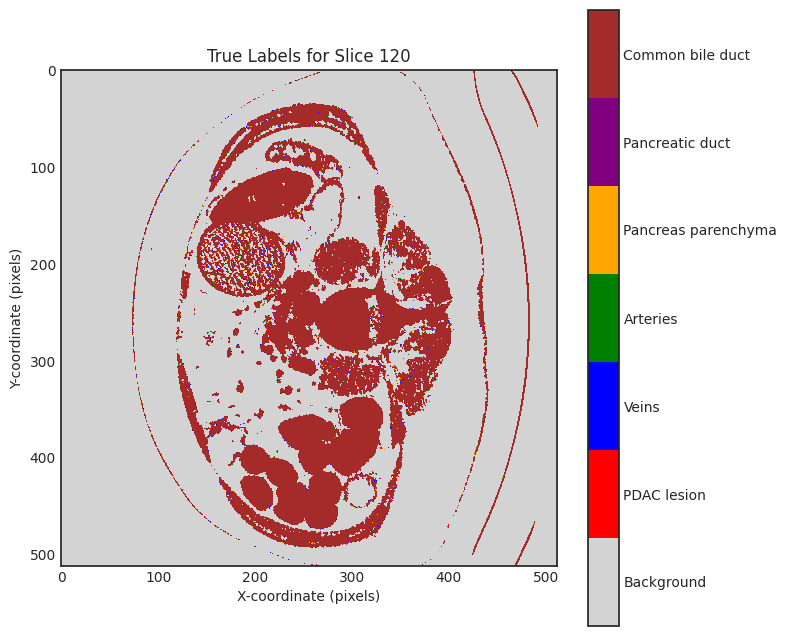

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(image_slice, cmap=cmap, norm=norm)
plt.title(f"True Labels for Slice {slice_index}")
plt.colorbar(
    ticks=range(len(label_annotations)),
    format=plt.FuncFormatter(lambda val, loc: label_annotations.get(val, "Unknown")),
)
plt.xlabel("X-coordinate (pixels)")
plt.ylabel("Y-coordinate (pixels)")
plt.show()

In [ ]:
pdac_mask = image_arr[:, :, slice_index] == 1

/home/bobby/miniconda3/envs/pdac_tversky/lib/python3.10/site-packages/matplotlib/colorbar.py:1223: RuntimeWarning: invalid value encountered in divide
  y = y / (self._boundaries[self._inside][-1] -


IndexError: index 1 is out of bounds for axis 0 with size 1

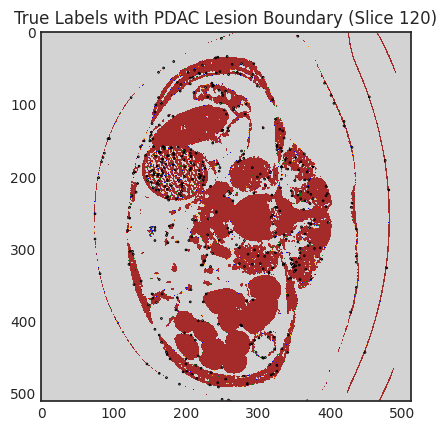

In [ ]:
plt.imshow(image_slice, cmap=cmap, norm=norm)

# Plot contours of the PDAC lesion
plt.contour(
    pdac_mask, colors="black", levels=[0.5]
)  # Levels=[0.5] makes it plot the boundary between 0 and 1
plt.title(f"True Labels with PDAC Lesion Boundary (Slice {slice_index})")
plt.colorbar(
    ticks=range(len(label_annotations)),
    format=plt.FuncFormatter(lambda val, loc: label_annotations.get(val, "Unknown")),
)
plt.xlabel("X-coordinate (pixels)")
plt.ylabel("Y-coordinate (pixels)")
plt.show()

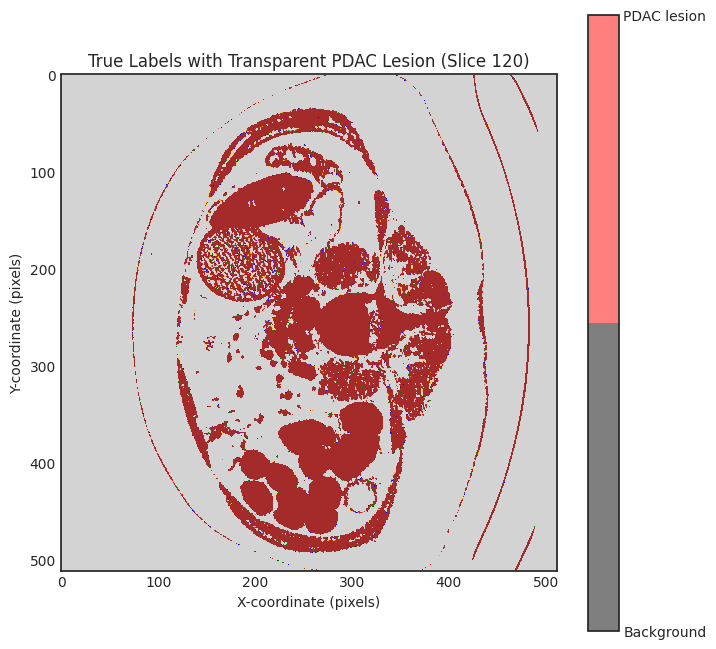

In [ ]:
pdac_only_slice = np.zeros_like(image_slice, dtype=float)
pdac_only_slice[image_slice == 1] = 1.0  # Set PDAC pixels to 1, others to 0

# Define a colormap for just the PDAC lesion (e.g., a red colormap)
cmap_pdac = ListedColormap(["none", "red"])  # 'none' for background, 'red' for PDAC

plt.figure(figsize=(8, 8))
# Plot the full labeled image first
plt.imshow(image_slice, cmap=cmap, norm=norm)
# Overlay the PDAC lesion with some transparency
plt.imshow(
    pdac_only_slice, cmap=cmap_pdac, alpha=0.5
)  # alpha makes it semi-transparent
plt.title(f"True Labels with Transparent PDAC Lesion (Slice {slice_index})")
plt.colorbar(
    ticks=range(len(label_annotations)),
    format=plt.FuncFormatter(lambda val, loc: label_annotations.get(val, "Unknown")),
)
plt.xlabel("X-coordinate (pixels)")
plt.ylabel("Y-coordinate (pixels)")
plt.show()

In [71]:
def contains_pdac_lession(label_image_file: str) -> np.ndarray:
    label_dist = get_label_distribution_for_image_labels(label_image_file)
    return label_dist.get(PDAC_LABEL, 0) > 0

In [72]:
np.unique([contains_pdac_lession(tl) for tl in true_labels], return_counts=True)

(array([False,  True]), array([162,  62]))

 `You have to use the same samples for the analysis of the old model and the newly trained model`


## ROC

* get the class probability thresholds [0, 1]
* determine if there is PDAC in the label
* get a confusion matrix for the test data, given the threshold
* get the true positive rate (TPR) and false positive rate (FPR)
* plot the ROC curve for all the thresholds
* get the area under the curve (AUC) for the ROC curve


# Samples
* get a sample with no PDAC and a sample with PDAC
* get the predicted probability (incl. class) for each sample
* get saggital, mid, and axial slices for each sample and plot the true labels on top
* plot the predicted PDAC area, segmentation, for each samples


## Mislabelled samples

* get samples where the model predicted PDAC but the label is not PDAC
* get samples where the model predicted no PDAC but the label is PDAC
* get the predicted (incl. class) for each sample
* get saggital, mid, and axial slices for each sample and plot the true labels on top
* plot the predicted PDAC area, segmentation, for each samples
